In [1]:
import os
import ast
import pandas as pd
import numpy as np
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/data')

In [2]:
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895
lat_centre =-42.10904672752227 ; lon_centre = 146.6417533511285;
gridlen=35

### cleanse

In [3]:
df=pd.read_csv('nva.csv')

In [4]:
df=df[['LONGITUDE','LATITUDE','OBSERVATION_DATE']]

In [5]:
df['OBSERVATION_DATE']=pd.to_datetime(df['OBSERVATION_DATE'],format='mixed')
df['year']=df['OBSERVATION_DATE'].dt.year
df=df[df['year']>=1985]

In [6]:
#assign each coordinate to the grid cell id
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
df['lat num']=(df['LATITUDE']-latmin)//latunit
df['lon num']=(df['LONGITUDE']-lonmin)//lonunit
df['id']=list(zip(df['lat num'].astype(int),df['lon num'].astype(int)))
df.reset_index(inplace=True,drop=True)

#remove areas outside of grid cell range
for i in range(len(df)):
    if int(df['id'][i][0])>=gridlen or \
    int(df['id'][i][-1])>=gridlen or \
    int(df['id'][i][0])<0 or int(df['id'][i][-1])<0:
        df.drop(i,inplace=True)

### disease threshold

In [7]:
#read
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/data')
disease=pd.read_csv('disease arrival.csv')

#convert to tuple
disease['id']=disease['id'].apply(lambda x:ast.literal_eval(x))

In [8]:
#get dftd arrival
correction=disease.merge(df,on='id',how='right')

#set year to float for comparison and dropna
correction['year_x']=correction['year_x'].astype(float)
correction['year_y']=correction['year_y'].astype(float)
correction=correction.loc[correction['year_x'].dropna().index]
correction=correction.loc[correction['year_y'].dropna().index]
correction['dftd']=np.where(correction['year_x']>=correction['year_y'],0,1)

#get northwest
ind1=correction[correction['id'].apply(lambda x:x[1])<=10].index

#get pre dftd based on cunningham et al. 2021
ind2=correction[correction['dftd']==0].index

#get pre disease data
pre_dftd=correction.loc[list(set(ind1).union(ind2))]

In [9]:
final=pre_dftd.groupby('id').count()[['dftd']]
final.reset_index(inplace=True)
final=final[['id','dftd']]
final['dftd']=np.log(final['dftd'])+1
final['index']=final['id'].apply(lambda x: (gridlen-1-x[0])*gridlen+x[1])
final[['index','dftd']].to_csv('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems/valid_spotlight.csv',index=False)

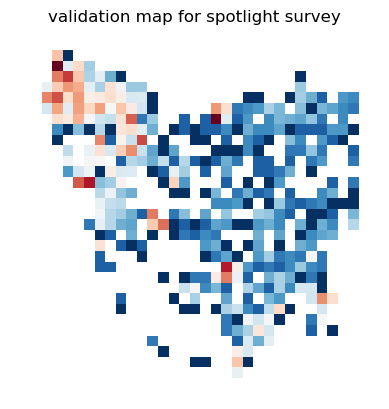

In [10]:
#generate raster
hs=np.zeros((gridlen,gridlen))

for i in final.index:
    hs[final.at[i,'id']]=final.at[i,'dftd']
hs=np.flip(hs,axis=0)

hs[hs==0]=np.nan

#viz
import matplotlib.pyplot as plt
plt.imshow(hs,cmap='RdBu_r',vmin=hs[~np.isnan(hs)].min(),
           vmax=hs[~np.isnan(hs)].max())
plt.title('validation map for spotlight survey')
plt.axis('off')
plt.show()